In [36]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
# 设置随机种子以确保结果可复现
np.random.seed(42)

In [37]:
# 读取数据并处理数据
path = "Z:\data\BTCUSDT\BTCUSDT-1h"
filelist = os.listdir(path)
filelist.sort()
df = pd.DataFrame()
for i in tqdm(filelist[-300:]):
    df0 = pd.read_csv(os.path.join(path, i))
    df = pd.concat([df, df0])

100%|██████████| 300/300 [00:01<00:00, 179.59it/s]


In [38]:
df1 = df[['open_time', 'open', 'high', 'low', 'close', 'volume']]
df1.columns = ['t', 'o', 'h', 'l', 'c', 'v']
df1 = df1.dropna()
df1

,t,o,h,l,c,v
0,1670976000000,17777.1,17833.9,17749.5,17817.8,10803.908
1,1670979600000,17817.8,17844.9,17772.3,17781.4,6999.399
2,1670983200000,17781.4,17815.3,17753.1,17795.1,5767.537
3,1670986800000,17795.1,17839.6,17782.4,17782.4,7150.765
4,1670990400000,17782.4,17790.5,17752.1,17772.1,5255.493
...,...,...,...,...,...,...
19,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886
20,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344
21,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588
22,1696888800000,27607.4,27627.0,27562.0,27575.9,3771.446


In [39]:
def calculate_rsi(prices, period=14):
    """计算相对强弱指数(RSI)"""
    deltas = np.diff(prices)
    seed = deltas[:period+1]
    up = seed[seed >= 0].sum()/period
    down = -seed[seed < 0].sum()/period
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:period] = 100. - 100./(1.+rs)

    for i in range(period, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta

        up = (up*(period-1) + upval)/period
        down = (down*(period-1) + downval)/period
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)

    return rsi

def prepare_data(data, window_size=5, forecast_days=1):
    """准备训练数据和标签"""
    df = data.copy()
    df['Return'] = df['c'].pct_change()
    df = df.dropna()

    # 创建技术指标
    df['SMA_5'] = df['c'].rolling(window=5).mean()
    df['SMA_10'] = df['c'].rolling(window=10).mean()
    df['SMA_20'] = df['c'].rolling(window=20).mean()

    df['EMA_5'] = df['c'].ewm(span=5, adjust=False).mean()
    df['EMA_10'] = df['c'].ewm(span=10, adjust=False).mean()
    df['EMA_20'] = df['c'].ewm(span=20, adjust=False).mean()

    df['MACD'] = df['EMA_10'] - df['EMA_20']

    df['RSI'] = calculate_rsi(df['c'], period=14)

    df = df.dropna()
    return df


In [40]:
df2=prepare_data(data=df1)
df2

,t,o,h,l,c,v,Return,SMA_5,SMA_10,SMA_20,EMA_5,EMA_10,EMA_20,MACD,RSI
20,1671048000000,17789.5,17944.4,17659.4,17762.1,63340.245,-0.001540,17990.56,17968.71,17884.225,17916.976707,17935.477344,17903.694340,31.783004,44.963372
21,1671051600000,17762.0,17845.6,17761.6,17827.9,14663.082,0.003705,17936.76,17969.12,17886.550,17887.284471,17915.917827,17896.475831,19.441996,49.121220
22,1671055200000,17828.1,17876.6,17790.1,17829.7,10964.469,0.000101,17884.84,17961.09,17888.280,17868.089648,17900.241858,17890.116228,10.125630,49.234205
23,1671058800000,17829.7,17841.9,17774.8,17803.9,9708.017,-0.001447,17802.62,17952.49,17889.355,17846.693098,17882.725157,17881.905159,0.819998,47.602491
0,1671062400000,17804.0,17849.5,17781.5,17788.7,11257.916,-0.000854,17802.46,17925.78,17890.185,17827.362066,17865.629674,17873.028477,-7.398803,46.622148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,1696878000000,27555.0,27632.4,27526.3,27607.6,8683.886,0.001913,27513.84,27496.50,27664.420,27546.755389,27555.948557,27628.414940,-72.466383,45.843090
20,1696881600000,27607.7,27644.0,27542.9,27556.2,4995.344,-0.001862,27538.48,27499.89,27651.790,27549.903593,27555.994274,27621.537327,-65.543053,42.854265
21,1696885200000,27556.1,27627.2,27542.3,27607.4,3540.588,0.001858,27581.74,27515.04,27634.740,27569.069062,27565.340770,27620.190915,-54.850145,46.589716
22,1696888800000,27607.4,27627.0,27562.0,27575.9,3771.446,-0.001141,27580.40,27530.10,27617.350,27571.346041,27567.260630,27615.972733,-48.712103,44.655694


In [41]:
# 创建数据X，y两个值
X=df2.drop('c', axis=1)
dates = pd.to_datetime(df2['t'], unit='ms')
X=X.drop('t',axis=1)
y=df2['c']

In [42]:
def train_bagging_model(X, y):
    """训练Bagging模型"""
    # 划分训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 创建和训练Bagging模型
    base_estimator = DecisionTreeRegressor(max_depth=5)
    bagging_model = BaggingRegressor(
        base_estimator,
        n_estimators=50,
        max_samples=0.8,
        max_features=0.8,
        bootstrap=True,
        bootstrap_features=True,
        n_jobs=-1,
        random_state=42
    )

    bagging_model.fit(X_train_scaled, y_train)

    # 在测试集上进行预测
    y_pred = bagging_model.predict(X_test_scaled)

    # 计算评估指标
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"均方误差 (MSE): {mse:.4f}")
    print(f"均方根误差 (RMSE): {rmse:.4f}")
    print(f"平均绝对误差 (MAE): {mae:.4f}")

    return bagging_model, scaler, X_train_scaled, X_test_scaled, y_train, y_test, y_pred

In [43]:
# 训练模型
model, scaler, X_train, X_test, y_train, y_test, y_pred = train_bagging_model(X, y)

均方误差 (MSE): 8325.5508
均方根误差 (RMSE): 91.2445
平均绝对误差 (MAE): 70.2041


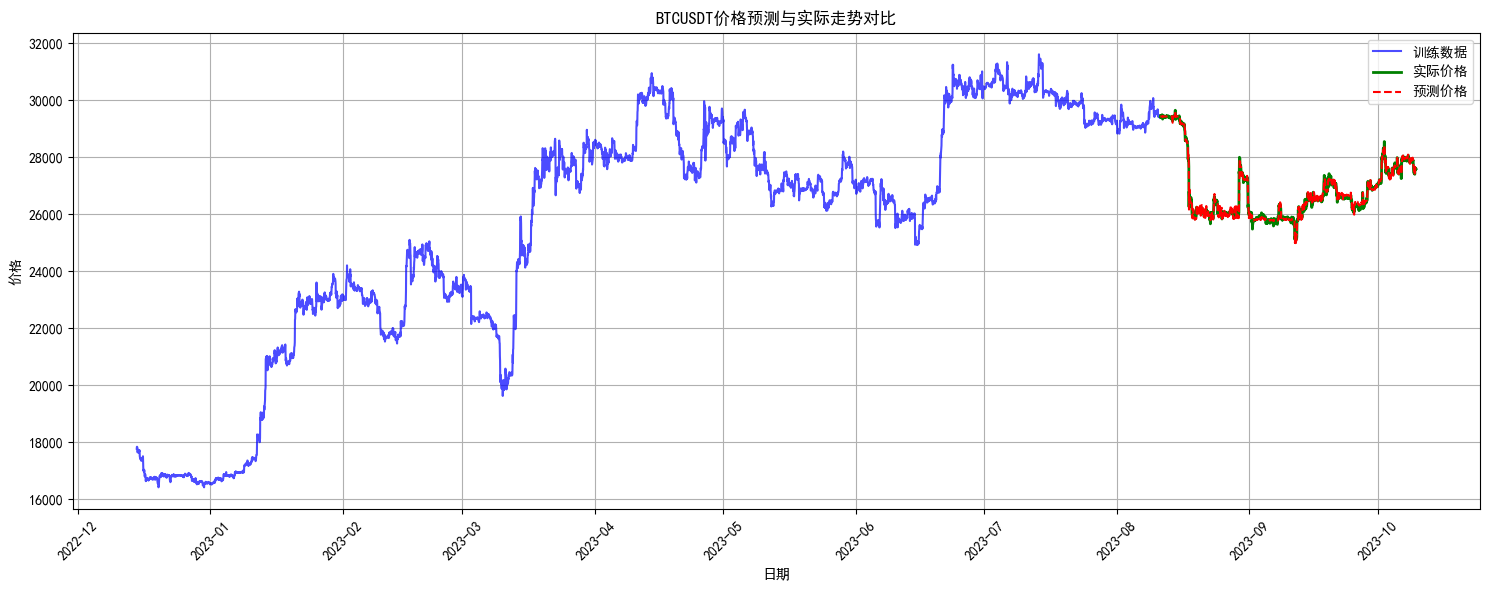

In [46]:
# 获取日期数据
def plot_predictions(actual_prices, predicted_prices, dates, train_size):
    """可视化预测结果"""
    plt.figure(figsize=(15, 6))

    # 绘制训练数据
    plt.plot(dates[:train_size], actual_prices[:train_size],
             label='训练数据', color='blue', alpha=0.7)

    # 绘制实际价格（测试数据）
    plt.plot(dates[train_size:], actual_prices[train_size:],
             label='实际价格', color='green', linewidth=2)

    # 绘制预测价格
    plt.plot(dates[train_size:], predicted_prices,
             label='预测价格', color='red', linestyle='--', linewidth=1.5)

    plt.title('BTCUSDT价格预测与实际走势对比')
    plt.xlabel('日期')
    plt.ylabel('价格')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 调用函数绘制预测结果
train_size = len(y_train)
actual_prices = np.concatenate([y_train, y_test])
plot_predictions(actual_prices, y_pred, dates, train_size)